# Урок 6. Детектирование объектов
## Домашнее задание  
__Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow].__

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета LFW

In [2]:
train_x, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incomplete20AEOT/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
# tfds.disable_progress_bar()
# (train_ds, test_ds), ds_info = tfds.load(
#     'food101', 
#     as_supervised=True,
#     with_info=True,
#     split=['train[:85%]', 'train[85%:]'],
# )

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

In [4]:
len(train_x)

13233

## Визуализация датасета LFW

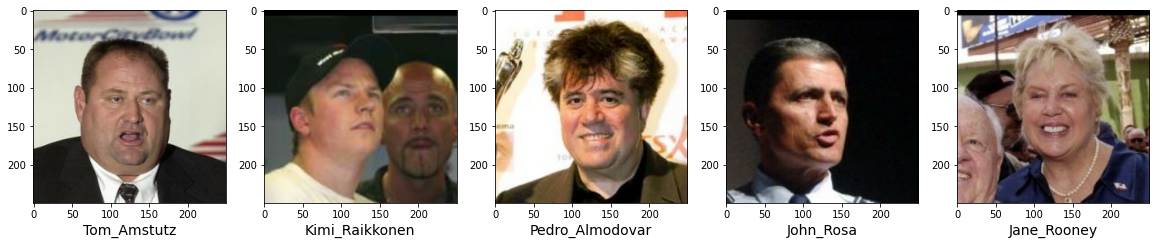

In [8]:
fig = plt.figure(figsize=(20, 15))
fontdict = {'fontsize': '14', 'color': 'black'}
for i, example in enumerate(train_x.take(5)):  # Only take a single example
    image, label = example[1], example[0]
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().astype(np.float32)/255)
    plt.xlabel(label.numpy().decode(), fontdict=fontdict)

In [9]:
for label,img in enumerate(train_x):
      print(label, img)
      break

0 (<tf.Tensor: shape=(), dtype=string, numpy=b'Tom_Amstutz'>, <tf.Tensor: shape=(250, 250, 3), dtype=uint8, numpy=
array([[[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       ...,

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 24,  22,  23],
        [ 23,  21,  22],
        [ 23,  21,  22]],

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 27,  25,  26],
        [ 25,  23,  24],
        [ 24,  22,  23]],

       [[ 30,  29,  25],
        [ 29,  28,  24

## Создание модели CNN

In [10]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [11]:
MARGIN = 50.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [12]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [13]:
BATCH_SIZE = 50
NUM_EPOCHS = 6

train_ds = train_x.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=1000, seed=5)
train_ds= train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

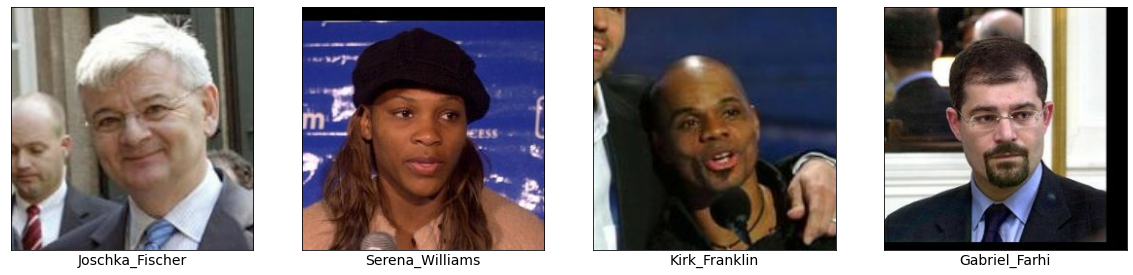

In [28]:
some_sample = next(iter(train_ds))
images = some_sample[1].numpy()[:4]
labels = some_sample[0].numpy()[:4]

fontdict = {'fontsize': '14', 'color': 'black'}
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode(), fontdict=fontdict)
plt.show()

## Подготовка к обучению

In [14]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [17]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 2396.82373046875
[200] Loss: 11.250016212463379
[400] Loss: 0.33065834641456604
[600] Loss: 0.0
[800] Loss: 0.0
[1000] Loss: 9.237107276916504
[1200] Loss: 0.0
[1400] Loss: 27.722471237182617
CPU times: user 2min 4s, sys: 14.7 s, total: 2min 19s
Wall time: 5min 24s


## Тестирование на новых данных

In [29]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_1 = load_and_prepare_image('/content/Joschka_Fischer.jpg')
img_2 = load_and_prepare_image('/content/Kirk_Franklin.jpg')
img_3 = load_and_prepare_image('/content/Serena_Williams.jpg')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


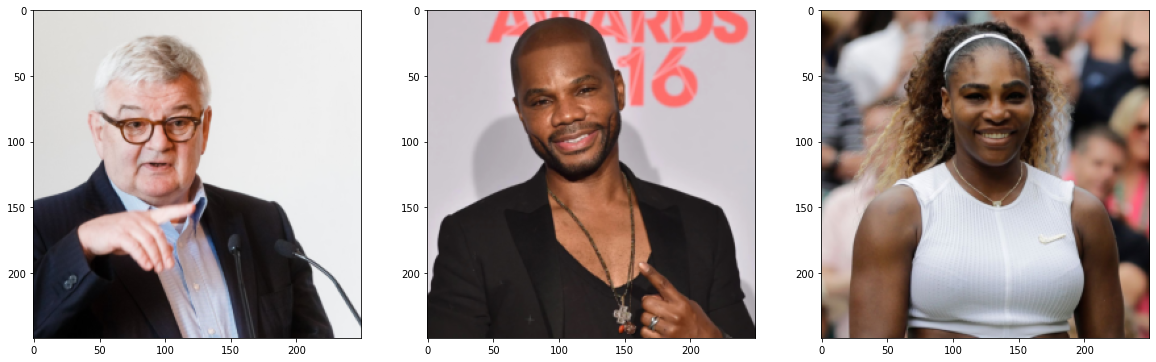

In [30]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_3)

plt.show()

## Получение эмбеддингов для новых данных

In [31]:
test_x = np.stack((img_1, img_2, img_3), axis=0)
test_embs = model(test_x)

Эмбединги тренировочных данных

In [32]:
train_embs = model(images)
emb_tr1 = train_embs[0,:] #Joschka_Fischer
emb_tr2 = train_embs[1,:] #Serena_Williams
emb_tr3 = train_embs[2,:] #Kirk_Franklin

Эмбединги новых данных

In [33]:
emb1 = test_embs[0,:] #Joschka_Fischer
emb2 = test_embs[1,:] #Kirk_Franklin
emb3 = test_embs[2,:] #Serena_Williams

## Вычисление расстояний между эмбеддингами

In [34]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [35]:
# На самих себе

print('Joschka_Fischer <-> Joschka_Fischer: ', diff(emb1, emb_tr1))
print('Kirk_Franklin <-> Kirk_Franklin: ', diff(emb2, emb_tr3))
print('Serena_Williams <-> Serena_Williams: ', diff(emb3, emb_tr2))

# На разных людях

print('Kirk_Franklin <-> Joschka_Fischer: ', diff(emb2, emb_tr1))
print('Kirk_Franklin <-> Serena_Williams: ', diff(emb2, emb_tr2))

Joschka_Fischer <-> Joschka_Fischer:  120.16386110484716
Kirk_Franklin <-> Kirk_Franklin:  68.99786285186666
Serena_Williams <-> Serena_Williams:  91.2733328473465
Kirk_Franklin <-> Joschka_Fischer:  91.30957494459439
Kirk_Franklin <-> Serena_Williams:  91.41390459402224


In [ ]:
# На данном этапе хорошо идентифицировать изображения не получилось. 